# Import Libraries

In [2]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Audio Processing
import librosa

# Data Manipulation
import pandas as pd
import numpy as np
from collections import Counter
from pathlib import Path
import random
import joblib

# Machine Learning dan Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Utility
from tqdm import tqdm

# Hugging Face Transformers
from transformers import AutoFeatureExtractor, AutoModel

# Configuration

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PRETRAINED_MODEL_NAME = "openai/whisper-large-v3"
PRETRAINED_MODEL_OUTPUT_DIM = 1280 # AutoConfig.from_pretrained(PRETRAINED_MODEL_NAME).d_model
PRETRAINED_MAX_LEN_PADDING = 448 # AutoConfig.from_pretrained(PRETRAINED_MODEL_NAME).max_length
SAMPLE_RATE = 16000 # Target sample rate

# Path ke file CSV
CSV_PATH = 'data.csv'

# Direktori untuk menyimpan model dan feature
MODEL_DIR = Path('./model')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FEATURE_DIR = Path('./model_features')
FEATURE_DIR.mkdir(parents=True, exist_ok=True)

# Extract Features

In [3]:
def extract_audio_features(
    dataframe: pd.DataFrame, 
    audio_file_column: str,
    feature_directory: Path = FEATURE_DIR,
    model_name: str = PRETRAINED_MODEL_NAME,
    target_sample_rate: int = SAMPLE_RATE,
    output_sequence_length: int = PRETRAINED_MAX_LEN_PADDING,
    extraction_device: str = DEVICE
):    
    saved_feature_paths = []
    processed_indices = []

    print(f"Memuat model pretrained: {model_name}")

    # Muat feature extractor dan model dari Hugging Face
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(extraction_device)
    
    # Gunakan encoder dari model untuk ekstraksi fitur dan set ke mode evaluasi
    model_encoder = model.get_encoder()
    model_encoder.eval()

    print(f"Memulai ekstraksi fitur ke direktori: {feature_directory}")

    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0], desc="Ekstraksi Fitur"):
        audio_path_str = str(row[audio_file_column])
        audio_path = Path(audio_path_str)

        def generate_safe_filename(path_obj: Path) -> str:
            """Membuat nama file yang aman dari path untuk menghindari konflik nama."""
            # Mengganti karakter pemisah path dengan underscore
            base_name = str(path_obj.with_suffix('')).replace('\\', '_').replace('/', '_').replace(':', '_')
            # Membersihkan underscore berlebih
            clean_name = '_'.join(filter(None, base_name.split('_')))
            # Jika nama kosong, buat nama unik menggunakan stem dan hash
            return clean_name or f"{path_obj.stem}_{hash(str(path_obj))}"

        feature_save_path = feature_directory / f"{generate_safe_filename(audio_path)}.pt"

        # Muat dan proses file audio
        waveform, original_sr = librosa.load(audio_path_str, sr=target_sample_rate, mono=True)
        
        # Ekstrak fitur menggunakan feature extractor
        inputs = feature_extractor(
            waveform, 
            sampling_rate=target_sample_rate, 
            return_tensors="pt", 
            padding="max_length", # Padding input ke panjang maksimal yang diterima model
            truncation=True
        )

        input_features = inputs.input_features.to(extraction_device)

        with torch.no_grad():
            # Dapatkan output dari encoder model
            outputs = model_encoder(input_features=input_features)
            
            # last_hidden_state berisi fitur yang diekstrak
            extracted_features = outputs.last_hidden_state.squeeze(0)

        # Standarisasi panjang sekuens output
        current_sequence_length = extracted_features.shape[0]
        if current_sequence_length > output_sequence_length:
            # Potong (truncate) jika lebih panjang
            final_features = extracted_features[:output_sequence_length, :]
        elif current_sequence_length < output_sequence_length:
            # Tambah padding jika lebih pendek
            padding_size = output_sequence_length - current_sequence_length
            padding_tensor = torch.zeros(padding_size, final_features.shape[1], device=final_features.device)
            final_features = torch.cat((extracted_features, padding_tensor), dim=0)
        else:
            final_features = extracted_features

        # Simpan tensor fitur ke file dan pindahkan ke CPU terlebih dahulu
        torch.save(final_features.cpu(), feature_save_path)
        saved_feature_paths.append(str(feature_save_path))
        processed_indices.append(index)

    # Buat DataFrame baru dari baris yang berhasil diproses
    processed_df = dataframe.loc[processed_indices].copy()
    processed_df['feature_path'] = saved_feature_paths
    
    return processed_df

In [ ]:
# Memuat CSV
df_original = pd.read_csv(CSV_PATH)

print(f"Dataframe original dimuat. Shape: {df_original.shape}")

# Ekstraksi dan penyimpanan fitur menggunakan model pra-latih
# Ini hanya perlu dijalankan sekali, atau jika data/parameter ekstraksi berubah.
# Setelah dijalankan, Anda bisa memberi komentar pada baris ini dan langsung memuat df_features jika sudah disimpan.
df_features = extract_audio_features(
    dataframe=df_original,
    audio_file_column='path',
    feature_directory=FEATURE_DIR,
    model_name=PRETRAINED_MODEL_NAME,
    target_sample_rate=SAMPLE_RATE,
    output_sequence_length=PRETRAINED_MAX_LEN_PADDING,
    extraction_device=DEVICE
)

df_features.to_csv(FEATURE_DIR / 'features_metadata.csv', index=False)

# Dataset

In [4]:
class EmotionDataset(Dataset):
    def __init__(self, 
                 data_df: pd.DataFrame, 
                 feature_col: str, 
                 label_col: str, 
                 label_encoder: LabelEncoder):
        self.data_df = data_df
        self.feature_col = feature_col
        self.label_col = label_col
        self.label_encoder = label_encoder

    def __len__(self) -> int:
        return len(self.data_df)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        # Dapatkan baris data pada indeks yang diberikan
        data_row = self.data_df.iloc[index]
        
        # Ambil path fitur dan nama label dari baris tersebut
        feature_path = data_row[self.feature_col]
        label_text = data_row[self.label_col]

        # Muat tensor fitur dari file (diasumsikan sudah di-CPU)
        feature_tensor = torch.load(feature_path)

        # Ubah label string menjadi representasi numerik menggunakan label_encoder
        # dan konversi menjadi tensor PyTorch dengan tipe data long
        label_id = self.label_encoder.transform([label_text])[0]
        label_tensor = torch.tensor(label_id, dtype=torch.long)
        
        return feature_tensor, label_tensor

# Model Architecture

In [11]:
class EmotionClassifierLSTM(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 hidden_dim: int, 
                 n_layers: int, 
                 num_classes: int, 
                 dropout_prob: float):
        super().__init__()

        # --- Layer LSTM ---
        # Menggunakan LSTM bidireksional untuk menangkap konteks dari kedua arah (maju dan mundur).
        # Dropout antar layer LSTM hanya aktif jika jumlah layer lebih dari 1.
        self.lstm_layer = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,  # Format input: (batch, sequence, feature)
            dropout=dropout_prob if n_layers > 1 else 0,
            bidirectional=True
        )

        # --- Classifier Head ---
        # Serangkaian layer fully-connected untuk melakukan klasifikasi akhir.
        # Input ke layer linear pertama adalah hidden_dim * 2 karena LSTM bersifat bidireksional,
        # yang menggabungkan output dari arah maju dan mundur.
        self.classifier_hidden_layer = nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu_activation = nn.ReLU()
        self.dropout_layer = nn.Dropout(dropout_prob)
        self.output_layer = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_features: torch.Tensor) -> torch.Tensor:
        # Dapatkan ukuran batch dari input
        batch_size = input_features.size(0)
        
        # Inisialisasi hidden state (h0) dan cell state (c0) untuk LSTM.
        # Dikalikan 2 pada dimensi pertama karena LSTM bidireksional.
        # Shape h0 & c0: (n_layers * 2, batch_size, hidden_dim)
        num_directions = 2
        h0 = torch.zeros(self.lstm_layer.num_layers * num_directions, batch_size, self.lstm_layer.hidden_size).to(input_features.device)
        c0 = torch.zeros(self.lstm_layer.num_layers * num_directions, batch_size, self.lstm_layer.hidden_size).to(input_features.device)

        # Lewatkan input melalui layer LSTM
        # lstm_output berisi output dari setiap time-step.
        # Shape lstm_output: (batch_size, sequence_length, hidden_dim * 2)
        lstm_output, _ = self.lstm_layer(input_features, (h0, c0))

        # Gunakan output dari time-step terakhir dari sekuens sebagai representasi keseluruhan.
        # Ini adalah strategi umum untuk tugas klasifikasi sekuens.
        # Shape last_step_output: (batch_size, hidden_dim * 2)
        last_step_output = lstm_output[:, -1, :]

        # Lewatkan representasi sekuens melalui classifier head
        x = self.classifier_hidden_layer(last_step_output)
        x = self.relu_activation(x)
        x = self.dropout_layer(x)
        logits = self.output_layer(x)

        return logits

# Data Loader and Data Split

In [7]:
# Data Splitting
df_features = pd.read_csv(FEATURE_DIR / 'features_metadata.csv')

# Encode label
label_encoder = LabelEncoder()
df_features['encoded_labels'] = label_encoder.fit_transform(df_features['labels'])
NUM_CLASSES = len(label_encoder.classes_)
print(f"Jumlah kelas: {NUM_CLASSES}")
print(f"Mapping kelas: {dict(zip(label_encoder.classes_, range(NUM_CLASSES)))}")

# Save label encoder
joblib.dump(label_encoder, MODEL_DIR / 'label_encoder.joblib')

# Split data
train_df, val_test_df = train_test_split(df_features, test_size=0.30, stratify=df_features['encoded_labels'], random_state=42)

# Pisahkan data validasi (15%) dan data uji (15%) dari sisanya (30%)
val_df, test_df = train_test_split(val_test_df, test_size=0.50, stratify=val_test_df['encoded_labels'], random_state=42)

print(f"Ukuran data training: {len(train_df)}")
print(f"Ukuran data validasi: {len(val_df)}")
print(f"Ukuran data uji: {len(test_df)}")

Jumlah kelas: 14
Mapping kelas: {'female_angry': 0, 'female_disgust': 1, 'female_fear': 2, 'female_happy': 3, 'female_neutral': 4, 'female_sad': 5, 'female_surprise': 6, 'male_angry': 7, 'male_disgust': 8, 'male_fear': 9, 'male_happy': 10, 'male_neutral': 11, 'male_sad': 12, 'male_surprise': 13}
Ukuran data training: 8513
Ukuran data validasi: 1824
Ukuran data uji: 1825


In [8]:
# Buat instance Dataset
train_dataset = EmotionDataset(
    data_df=train_df,
    feature_col="feature_path",
    label_col="labels",
    label_encoder=label_encoder,
)

val_dataset = EmotionDataset(
    data_df=val_df,
    feature_col="feature_path",
    label_col="labels",
    label_encoder=label_encoder,
)

test_dataset = EmotionDataset(
    data_df=test_df,
    feature_col="feature_path",
    label_col="labels",
    label_encoder=label_encoder,
)

NameError: name 'EmotionDataset' is not defined

In [9]:
# Handle class imbalance (WeightedRandomSampler)
train_labels_encoded = train_df['encoded_labels'].tolist()
class_counts = Counter(train_labels_encoded)

class_weights = {i: 1.0/count for i, count in class_counts.items() if count > 0}
sample_weights = [class_weights[label] for label in train_labels_encoded if label in class_weights]
weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [9]:
# Data Loader
BATCH_SIZE = 16 # [16, 32, 64, 128]

# Buat instance DataLoader
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler, pin_memory=True,
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, drop_last=False
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, drop_last=False
)

# Uji satu batch
print("\nMenguji DataLoader dengan fitur pra-latih...")
try:
    sample_features, sample_labels = next(iter(train_loader))
    print(f"Bentuk batch Fitur: {sample_features.shape}") # Harusnya (BATCH_SIZE, PRETRAINED_MAX_LEN_PADDING, PRETRAINED_MODEL_OUTPUT_DIM)
    print(f"Bentuk batch labels: {sample_labels.shape}")
except Exception as e:
    print(f"Error saat mengambil batch dari DataLoader: {e}")


Menguji DataLoader dengan fitur pra-latih...
Bentuk batch Fitur: torch.Size([16, 448, 1280])
Bentuk batch labels: torch.Size([16])


# Preparation

In [12]:
# Konfigurasi 
LSTM_HIDDEN_SIZE = 256 # [64, 128, 256, 512]
LSTM_NUM_LAYERS = 3
LSTM_DROPOUT = 0.3

# Parameter Early Stopping
LEARNING_RATE = 1e-4 # [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

In [13]:
model = EmotionClassifierLSTM(
    input_dim=PRETRAINED_MODEL_OUTPUT_DIM,
    hidden_dim=LSTM_HIDDEN_SIZE,
    n_layers=LSTM_NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout_prob=LSTM_DROPOUT
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

print("\nModel Summary:")
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


Model Summary:
EmotionClassifierLSTM(
  (lstm_layer): LSTM(1280, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (classifier_hidden_layer): Linear(in_features=512, out_features=256, bias=True)
  (relu_activation): ReLU()
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=256, out_features=14, bias=True)
)
Total trainable parameters: 6438670


# Loop function

In [12]:
def run_epoch(mode="train", model=None, data_loader=None, optimizer=None, criterion=None, device=None):
    if mode == "train":
        model.train()  # Set model ke mode training
    else:
        model.eval()   # Set model ke mode evaluasi

    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Wrapper untuk progress bar, sesuaikan deskripsi berdasarkan mode
    progress_bar_desc = "Training Epoch" if mode == "train" else "Evaluating Epoch"
    
    # Kondisi untuk torch.no_grad() hanya berlaku pada mode evaluasi
    if mode == "val":
        with torch.no_grad():
            for inputs, labels in tqdm(data_loader, desc=progress_bar_desc, leave=False):
                inputs, labels = inputs.to(device), labels.to(device)

                # Lewati batch kosong jika ada (meskipun jarang terjadi dengan DataLoader standar)
                if inputs.nelement() == 0: 
                    continue

                outputs = model(inputs)
                
                # Lewati jika output kosong (jarang, tapi untuk keamanan)
                if outputs.nelement() == 0:
                    continue
                
                loss = criterion(outputs, labels)

                total_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
    else: # mode == "train"
        for inputs, labels in tqdm(data_loader, desc=progress_bar_desc, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            if inputs.nelement() == 0:
                continue

            optimizer.zero_grad()
            outputs = model(inputs)

            if outputs.nelement() == 0:
                continue
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    if total_samples == 0:
        # Ini bisa terjadi jika data_loader kosong
        print(f"Peringatan: Tidak ada sampel yang diproses dalam mode {mode}.")
        return 0.0, 0.0 
        
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

# Run training

In [ ]:
EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 1e-4

# Inisialisasi history dan variabel early stopping
train_losses_history = []
val_losses_history = []
train_accs_history = []
val_accs_history = []

epochs_no_improve = 0
best_val_loss_early_stopping = float('inf')
early_stop_triggered = False

# Tentukan path model terbaik
model_name_suffix = PRETRAINED_MODEL_NAME.split("/")[-1] if "/" in PRETRAINED_MODEL_NAME else PRETRAINED_MODEL_NAME
best_model_path = MODEL_DIR / f'best_lstm_with_{model_name_suffix}_features.pth'

best_val_accuracy_overall = 0.0
epoch_counter = 0

print(f"\nMemulai Training dengan Early Stopping (Fitur Pra-Latih dari: {model_name_suffix})...")
print(f"Model terbaik akan disimpan di: {best_model_path}")
print(f"Early stopping: Patience={EARLY_STOPPING_PATIENCE} epochs, Min Delta={EARLY_STOPPING_MIN_DELTA}")

while True:
    epoch_counter += 1
    print(f"\n--- Epoch {epoch_counter} ---")

    # Training epoch
    train_loss, train_acc = run_epoch("train", model, train_loader, optimizer, criterion, DEVICE)
    
    # Validation epoch
    val_loss, val_acc = run_epoch("val", model, val_loader, None, criterion, DEVICE)

    train_losses_history.append(train_loss)
    train_accs_history.append(train_acc)
    val_losses_history.append(val_loss)
    val_accs_history.append(val_acc)

    print(f"Epoch {epoch_counter}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {val_loss:.4f}, Val Acc  : {val_acc:.4f}")

    # Logika Early Stopping dan penyimpanan model terbaik berdasarkan val_loss
    if val_loss < best_val_loss_early_stopping - EARLY_STOPPING_MIN_DELTA:
        best_val_loss_early_stopping = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"  Val loss membaik. Model disimpan ke {best_model_path}")
    else:
        epochs_no_improve += 1
        print(f"  Val loss tidak membaik (atau perbaikan < {EARLY_STOPPING_MIN_DELTA}) selama {epochs_no_improve} epoch(s).")

    # Lacak akurasi validasi terbaik secara keseluruhan (opsional, tapi bagus untuk info)
    if val_acc > best_val_accuracy_overall: 
        best_val_accuracy_overall = val_acc
        # Anda juga bisa menyimpan model berdasarkan akurasi validasi terbaik jika diinginkan
        torch.save(model.state_dict(), MODEL_DIR / f'best_accuracy_model_{model_name_suffix}.pth')
        print(f"  Val accuracy membaik menjadi {best_val_accuracy_overall:.4f}.")

    # Cek kondisi early stopping
    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping dipicu pada epoch {epoch_counter} setelah {EARLY_STOPPING_PATIENCE} epoch tanpa perbaikan signifikan pada validation loss.")
        early_stop_triggered = True
        break # Keluar dari loop while True

print("\n--- Training Selesai ---")
if early_stop_triggered:
    print("Training dihentikan lebih awal oleh early stopping.")
    print(f"Model terbaik (berdasarkan val loss) disimpan di: {best_model_path}")
    print(f"Val loss terbaik (pada saat penyimpanan): {best_val_loss_early_stopping:.4f}")

print(f"Akurasi validasi terbaik keseluruhan yang dicapai: {best_val_accuracy_overall:.4f}")

# Plotting

In [ ]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs, best_val_loss):
    epochs = len(train_losses)
    if epochs == 0:
        print("No training data to plot.")
        return
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    x_range = range(1, epochs + 1)
    
    # Plot losses
    ax1.plot(x_range, train_losses, label='Training Loss')
    ax1.plot(x_range, val_losses, label='Validation Loss')
    if best_val_loss != float('inf') and val_losses:
        best_epoch = np.argmin(val_losses) + 1
        ax1.axvline(best_epoch, linestyle='--', color='r', 
                    label=f'Best Val Loss Epoch ({best_epoch})')
    ax1.set(xlabel='Epoch', ylabel='Loss', title='Training & Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(x_range, train_accs, label='Training Training Accuracy')
    ax2.plot(x_range, val_accs, label='Validation Accuracy')
    if best_val_loss != float('inf') and val_losses:
        ax2.axvline(best_epoch, linestyle='--', color='r',
                    label=f'Best Val Loss Epoch ({best_epoch})')
    ax2.set(xlabel='Epoch', ylabel='Accuracy', title='Training & Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    
    # Save plot to model_features folder
    plt.savefig('model/training_history.png')
    plt.show()

# Call the function with history data
plot_training_history(
    train_losses_history,
    val_losses_history, 
    train_accs_history,
    val_accs_history,
    best_val_loss_early_stopping
)

# Sanity Check with Test Data

In [14]:
best_model_path = "model/best_lstm_with_whisper-large-v3_features.pth"
print(f"\nMemuat model terbaik dari {best_model_path}...")
model.load_state_dict(torch.load(best_model_path))
model.to(DEVICE) # Pastikan model kembali ke device yang benar
model.eval() # Set ke mode evaluasi


Memuat model terbaik dari model/best_lstm_with_whisper-large-v3_features.pth...


EmotionClassifierLSTM(
  (lstm_layer): LSTM(1280, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (classifier_hidden_layer): Linear(in_features=512, out_features=256, bias=True)
  (relu_activation): ReLU()
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=256, out_features=14, bias=True)
)

100%|██████████| 115/115 [00:17<00:00,  6.44it/s]


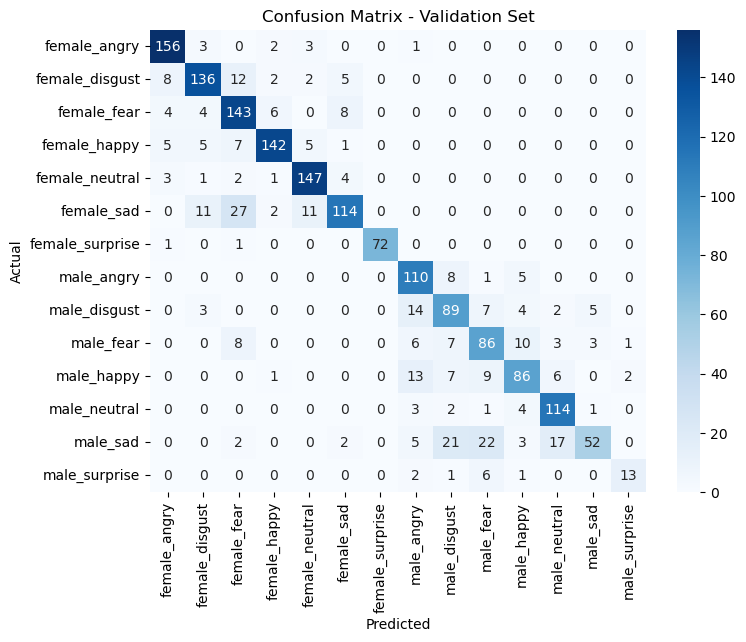


Laporan Klasifikasi - Validation Set:
                 precision    recall  f1-score   support

   female_angry       0.88      0.95      0.91       165
 female_disgust       0.83      0.82      0.83       165
    female_fear       0.71      0.87      0.78       165
   female_happy       0.91      0.86      0.88       165
 female_neutral       0.88      0.93      0.90       158
     female_sad       0.85      0.69      0.76       165
female_surprise       1.00      0.97      0.99        74
     male_angry       0.71      0.89      0.79       124
   male_disgust       0.66      0.72      0.69       124
      male_fear       0.65      0.69      0.67       124
     male_happy       0.76      0.69      0.73       124
   male_neutral       0.80      0.91      0.85       125
       male_sad       0.85      0.42      0.56       124
  male_surprise       0.81      0.57      0.67        23

       accuracy                           0.80      1825
      macro avg       0.81      0.78      0.79 

In [36]:
def get_predictions(model, data_loader, device):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds.extend(torch.max(outputs, 1)[1].cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return np.array(preds), np.array(labels)

# Memuat model terbaik jika ada
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

# Mendapatkan prediksi dan label dari test set
y_pred, y_true = get_predictions(model, test_loader, DEVICE)

class_names = label_encoder.classes_

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Laporan Klasifikasi
print("\nLaporan Klasifikasi - Validation Set:")
try:
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
except ValueError:
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"Mapping ID ke nama kelas: {dict(enumerate(class_names))}")

In [37]:
def run_sanity_checks(current_model, test_df, label_encoder, device, num_checks=20):
    current_model.eval()  # Mode evaluasi
    correct_predictions = 0
    
    print("--- Memulai Sanity Check Model ---")
    total_samples = len(test_df)
    sample_size = min(num_checks, total_samples)
    indices = random.sample(range(total_samples), sample_size)

    for idx, df_idx in enumerate(indices):
        row = test_df.iloc[df_idx]
        feature_path = row['feature_path']
        true_label = row['labels']

        # Load fitur dan prediksi
        with torch.no_grad():
            feature_tensor = torch.load(feature_path, map_location=device).unsqueeze(0)
            output = current_model(feature_tensor)
            _, predicted_id = torch.max(output, 1)
            predicted_label = label_encoder.inverse_transform(predicted_id.cpu().numpy())[0]

        # Tampilkan hasil
        original_audio_path = row.get('path', 'Tidak tersedia')
        print(f"\nSampel {idx+1}/{sample_size}:")
        print(f"   Audio Asli       : {original_audio_path}")
        print(f"   File Fitur       : {feature_path}")
        print(f"   Label Sebenarnya : {true_label}")
        print(f"   Prediksi Model   : {predicted_label}")
        result = "Benar" if true_label == predicted_label else "SALAH"
        print(f"   Hasil            : {result}")

        if true_label == predicted_label:
            correct_predictions += 1

    # Ringkasan akhir
    accuracy = (correct_predictions / sample_size) * 100 if sample_size > 0 else 0
    print("\n--- Ringkasan Sanity Check ---")
    print(f"Total sampel dicek : {sample_size}")
    print(f"Prediksi benar     : {correct_predictions}")
    print(f"Akurasi            : {accuracy:.2f}%")
    print("--- Sanity Check Selesai ---")

In [38]:
NUM_SANITY_CHECKS = 20
label_encoder = joblib.load(MODEL_DIR / "label_encoder.joblib")
run_sanity_checks(model, test_df, label_encoder, DEVICE, NUM_SANITY_CHECKS)

--- Memulai Sanity Check Model ---

Sampel 1/20:
   Audio Asli       : data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-03-02-01-01-01.wav
   File Fitur       : model_features\data_ravdess-emotional-speech-audio_audio_speech_actors_01-24_Actor_01_03-01-03-02-01-01-01.pt
   Label Sebenarnya : male_happy
   Prediksi Model   : male_surprise
   Hasil            : SALAH

Sampel 2/20:
   Audio Asli       : data/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_soup_fear.wav
   File Fitur       : model_features\data_toronto-emotional-speech-set-tess_TESS Toronto emotional speech set data_TESS Toronto emotional speech set data_YAF_fear_YAF_soup_fear.pt
   Label Sebenarnya : female_fear
   Prediksi Model   : female_fear
   Hasil            : Benar

Sampel 3/20:
   Audio Asli       : data/surrey-audiovisual-expressed-emotion-savee/ALL/DC_h01.wav
   File Fitur       : model_features\data_surrey-

In [18]:
def predict_single_audio_file(
    file_path: str,
    feature_extractor,
    feature_extraction_model,
    classification_model,
    label_encoder_obj,
    target_sample_rate: int,
    max_len_padding_output: int,
    device: torch.device,
) -> str:
    waveform, sr = librosa.load(file_path, sr=target_sample_rate, mono=True)
    print(f"Audio dimuat dari: {file_path}, Durasi: {len(waveform) / sr:.2f}s")

    inputs = feature_extractor(
        waveform,
        sampling_rate=target_sample_rate,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
    )

    input_data = inputs.input_features
    model_input_kwarg_name = "input_features"

    input_for_extraction_model = input_data.to(device)

    feature_extraction_model.eval()  # Pastikan model ekstraksi dalam mode eval
    with torch.no_grad():
        model_kwargs = {model_input_kwarg_name: input_for_extraction_model}
        outputs_extraction = feature_extraction_model(**model_kwargs)
        raw_extracted_features = outputs_extraction.last_hidden_state.squeeze(0)

    seq_len_model = raw_extracted_features.shape[0]
    final_features_for_classifier = raw_extracted_features  # Inisialisasi

    if seq_len_model > max_len_padding_output:
        final_features_for_classifier = raw_extracted_features[:max_len_padding_output, :]
    elif seq_len_model < max_len_padding_output:
        padding_needed = max_len_padding_output - seq_len_model
        padding_tensor = torch.zeros(padding_needed, raw_extracted_features.shape[1], device=device)
        final_features_for_classifier = torch.cat((raw_extracted_features, padding_tensor), dim=0)

    final_features_for_classifier = final_features_for_classifier.to(device)

    feature_tensor_batch = final_features_for_classifier.unsqueeze(0)

    classification_model.eval()  # Pastikan model klasifikasi dalam mode eval
    with torch.no_grad():
        output_logits = classification_model(feature_tensor_batch)
        _, predicted_id = torch.max(output_logits, 1)

    predicted_label_name = label_encoder_obj.inverse_transform(predicted_id.cpu().numpy())[0]

    return predicted_label_name

In [15]:
# Asumsikan variabel-variabel berikut sudah Anda inisialisasi dan muat:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRETRAINED_MODEL_NAME)
pretrained_model = AutoModel.from_pretrained(PRETRAINED_MODEL_NAME).to(DEVICE)
feature_extraction_model = pretrained_model.get_encoder()
feature_extraction_model.eval()
model.eval()

EmotionClassifierLSTM(
  (lstm_layer): LSTM(1280, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (classifier_hidden_layer): Linear(in_features=512, out_features=256, bias=True)
  (relu_activation): ReLU()
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=256, out_features=14, bias=True)
)

In [20]:
# Path ke file audio yang diunggah (misalnya, disimpan sementara)
uploaded_audio_file = "local_test_set/female_2.wav"

# Lakukan prediksi
predicted_label = predict_single_audio_file(
    file_path=uploaded_audio_file,
    feature_extractor=feature_extractor,
    feature_extraction_model=feature_extraction_model,
    classification_model=model,
    label_encoder_obj=label_encoder,
    target_sample_rate=SAMPLE_RATE,
    max_len_padding_output=PRETRAINED_MAX_LEN_PADDING,
    device=DEVICE,
)

print(f"\nLabel yang Diprediksi untuk '{uploaded_audio_file}': {predicted_label}")

Audio dimuat dari: local_test_set/female_2.wav, Durasi: 2.34s

Label yang Diprediksi untuk 'local_test_set/female_2.wav': female_disgust
